<a href="https://colab.research.google.com/github/samyaknd/movie-revenue-prediction/blob/main/movie_revenue_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb

!pip install catboost
import catboost

from wordcloud import WordCloud
from collections import Counter
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNet, ElasticNetCV, Ridge, RidgeCV, LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from keras import models, layers, regularizers, optimizers

### 1. Data Loading and Cleanup

I take look at columns that have significant amount of missing values
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNet, ElasticNetCV, Ridge, RidgeCV, LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from keras import models, layers, regularizers, optimizers
Also, In the dataset I saw that a few of the columns are JSON like strings, so I converted them to dictionaries so that they are easier to work with.

In [126]:
train=pd.read_csv('/content/train.csv')
test=pd.read_csv('/content/test.csv')

print(test.shape)
print(train.shape)
train.info()


(4398, 22)
(3000, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-nu

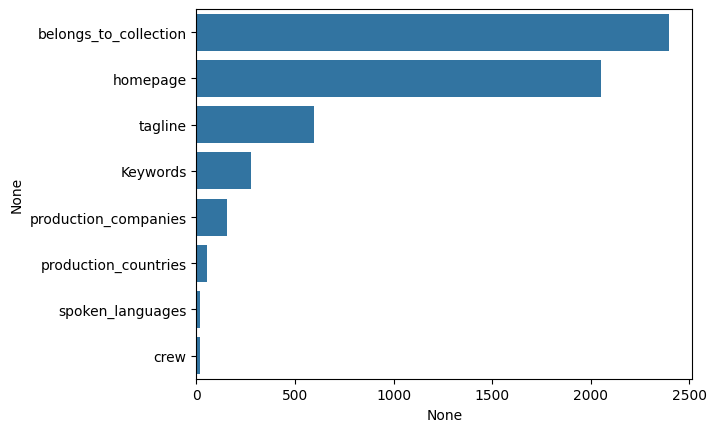

In [127]:
missing = train.isna().sum().sort_values(ascending=False)
sns.barplot(x=missing[:8],y=missing[:8].index)
plt.show()

In [128]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def safe_literal_eval(val):
    try:
        if isinstance(val, str):
            return ast.literal_eval(val)
        elif isinstance(val, (dict, list)):
            return val
        else:
            return {}
    except (ValueError, SyntaxError):
        return {}

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if x is None else safe_literal_eval(x))
    return df

print("Before transformation types:")
print(train['belongs_to_collection'].apply(type).head())

dfx = text_to_dict(train)
for col in dict_columns:
    train[col] = dfx[col]

print("After transformation types:")
print(train['belongs_to_collection'].apply(type).head())


Before transformation types:
0      <class 'str'>
1      <class 'str'>
2    <class 'float'>
3    <class 'float'>
4    <class 'float'>
Name: belongs_to_collection, dtype: object
After transformation types:
0    <class 'list'>
1    <class 'list'>
2    <class 'dict'>
3    <class 'dict'>
4    <class 'dict'>
Name: belongs_to_collection, dtype: object


In [129]:
dfx = text_to_dict(test)
for col in dict_columns:
    test[col] = dfx[col]

#### EDA Part 1:

I am going to do EDA on the following columns:

**belongs_to_collection:** Understanding the distribution and frequency of movie collections can reveal insights into the prevalence of franchises within the dataset, offering valuable information for analyzing patterns in movie success and audience engagement.

**tagline:** Examining the presence of taglines across movies allows for an understanding of how frequently movies utilize taglines as part of their marketing strategies, shedding light on their potential impact on audience perception and box office performance.

**keywords:** Investigating the most frequent and significant keywords within the movie dataset enables the identification of recurring themes and topics across films, providing valuable insights into audience interests and potential genre trends.

**production_companies:** Analyzing production companies' involvement in movie production offers insights into industry dynamics, highlighting the most active players and potential associations between production companies and specific movie genres or themes.

**production_countries:** Exploring production countries reveals global film industry trends, showcasing the dominance of key markets like Hollywood and identifying emerging film industries. It also reflects cultural influences, aids in localization strategies, and promotes diversity in filmmaking through international collaborations.

**spoken_languages:** Examining spoken languages in movies provides insights into audience demographics and preferences, aiding in localization efforts and marketing strategies tailored to specific language-speaking regions. It also reflects cultural diversity in filmmaking and highlights opportunities for language-specific content creation.

**genres:** Understanding the distribution of movie genres allows for insights into audience preferences and trends, aiding in content strategy and marketing decisions. It also provides context for analyzing the success and popularity of different genres within the movie dataset.

belongs_to_collection
0    2396
1     604
Name: count, dtype: int64


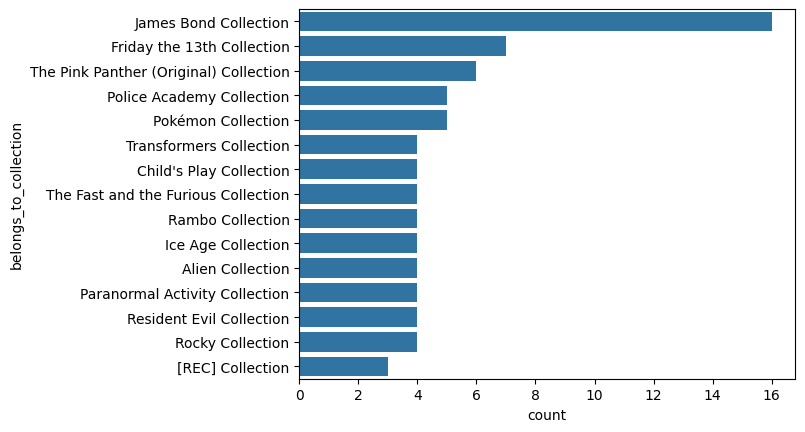

In [130]:
collections_count = train['belongs_to_collection'].apply(lambda x: len(x) if x else 0).value_counts()
print(collections_count)

top_collections = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x else None).value_counts()[0:15]
sns.barplot(x=top_collections, y=top_collections.index)
plt.show()

tagline
1    2403
0     597
Name: count, dtype: int64


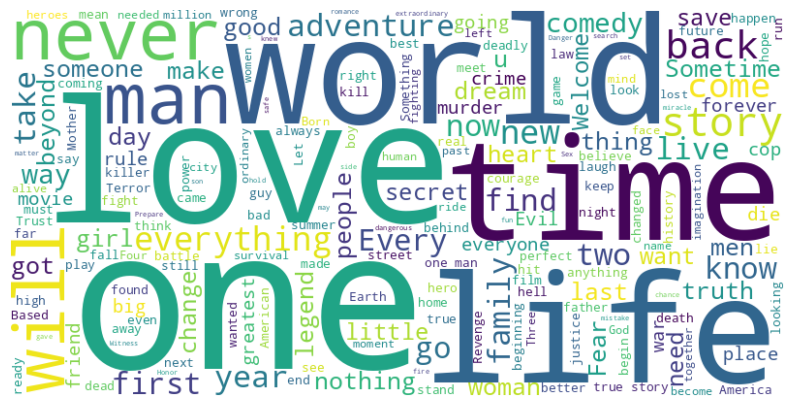

In [131]:
tagline_presence = train['tagline'].notna().astype(int).value_counts()
print(tagline_presence)

plt.figure(figsize=(10, 10))
all_taglines = ' '.join(train['tagline'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_taglines)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

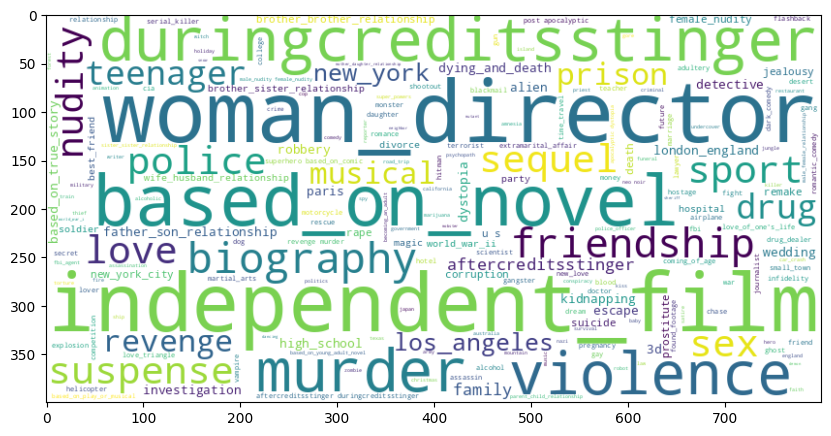

In [132]:
def extract_keywords(keywords):
  return [kw['name'] for kw in keywords] if isinstance(keywords, list) else []

list_of_keywords = train['Keywords'].apply(extract_keywords).tolist()
text = ' '.join('_'.join(kw.split()) for kws in list_of_keywords for kw in kws)

plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [133]:
# def extract_country_names(countries):
#   return [country['name'] for country in countries] if isinstance(countries, list) else []

# country_names = train['production_countries'].apply(extract_country_names).tolist()

# country_count = Counter([name for sublist in country_names for name in sublist]).most_common(10)

# sns.barplot(x=[val[1] for val in country_count], y=[val[0] for val in country_count])
# plt.show()

# Here, I have written an abstraction for the above function so that I can resue it for different features

def extract_names(data, column_name, name_key):
    return [item[name_key] for sublist in data[column_name] for item in sublist] if isinstance(data[column_name].iloc[0], list) else []

def plot_most_common(data, column_name, name_key, top_n=10):
    names = extract_names(data, column_name, name_key)
    name_count = Counter(names).most_common(top_n)

    sns.barplot(x=[val[1] for val in name_count], y=[val[0] for val in name_count])
    plt.xlabel('Count')
    plt.ylabel('Name')
    plt.title(f'Top {top_n} Most Common {column_name.capitalize()}')
    plt.show()

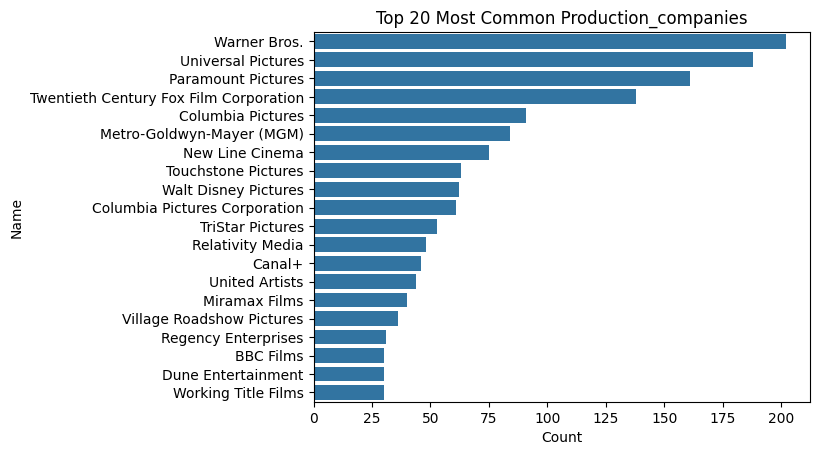

In [134]:
plot_most_common(train, 'production_companies', 'name', top_n=20)

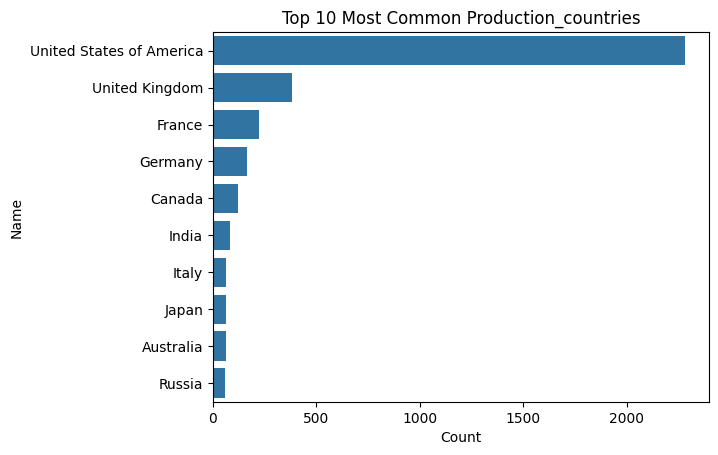

In [135]:
plot_most_common(train, 'production_countries', 'name', top_n=10)

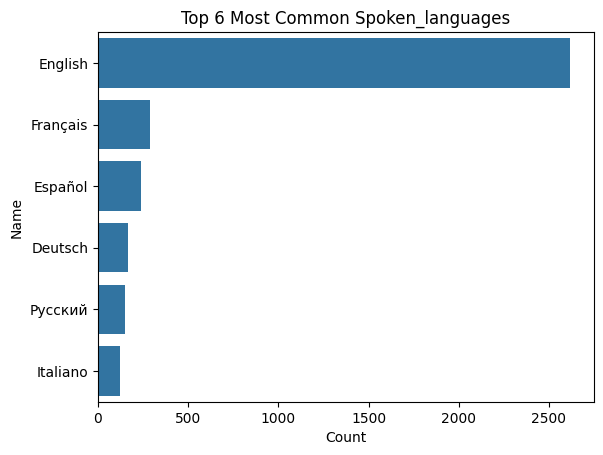

In [136]:
plot_most_common(train, 'spoken_languages', 'name', top_n=6)

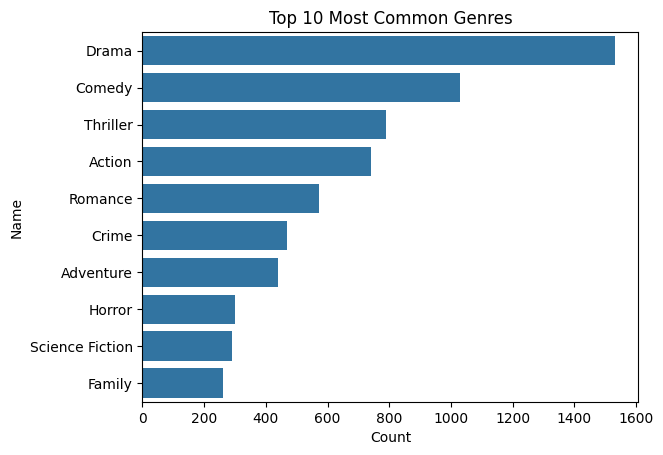

In [137]:
plot_most_common(train, 'genres', 'name', top_n=10)

### EDA Part 2:

Here I will do analysis on the features and their relation to the target variable revenue.

**Log Transformation of Revenue and Budget:**
Log-transforming the revenue and budget variables helps in dealing with skewness and visualizing potential non-linear relationships.

**Budget vs. Revenue:** By plotting budget against revenue, I can observe the correlation between movie budgets and revenues.

**Popularity vs. Revenue:** This plot helps me understand whether more popular movies tend to generate higher revenues.

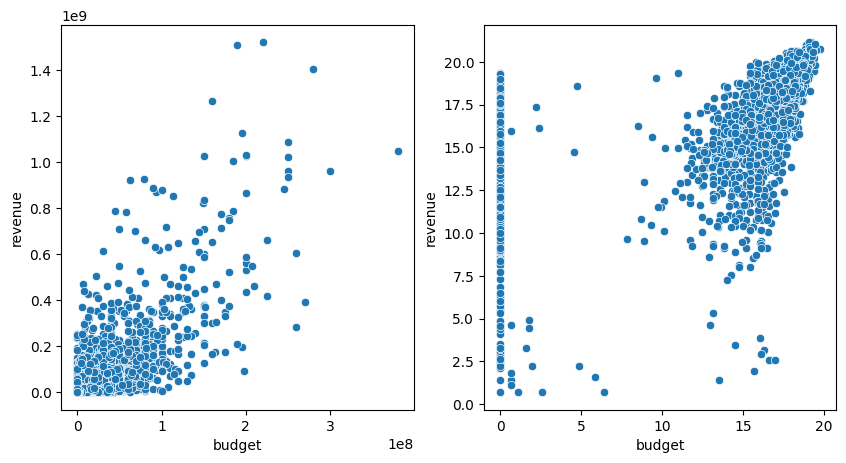

In [138]:
train['log_revenue'] = np.log1p(train['revenue'])
train['log_budget'] = np.log1p(train['budget'])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.scatterplot(x=train['budget'],y=train['revenue'])
plt.subplot(1,2,2)
sns.scatterplot(x=np.log1p(train['budget']),y=np.log1p(train['revenue']))
plt.show()

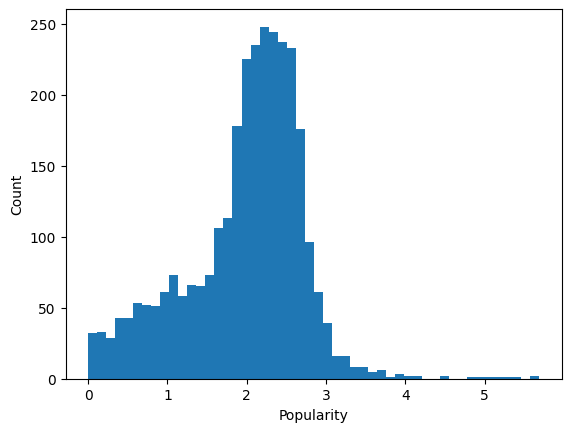

In [139]:
plt.hist(np.log1p(train['popularity']), bins=50)
plt.xlabel('Popularity')
plt.ylabel('Count')
plt.show()

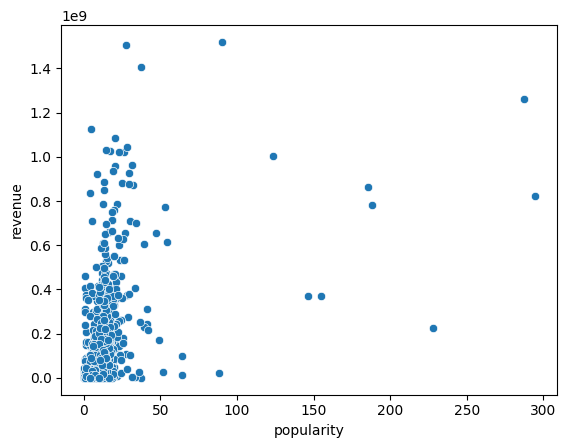

In [140]:
sns.scatterplot(x=train['popularity'],y=train['revenue'])
plt.show()

### EDA Part 3

Performing Exploratory Data Analysis (EDA) on date-related features is crucial as it helps uncover temporal patterns and trends that influence movie performance, such as seasonal peaks or day-of-week preferences for releases. Understanding these patterns can guide the prediction of movie revenue by identifying optimal release times and periods of high competition. Additionally, EDA on date features allows for the identification and correction of data anomalies, ensuring the accuracy and reliability of subsequent analyses and models.

<ipython-input-141-0542dcc27805>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation='vertical')


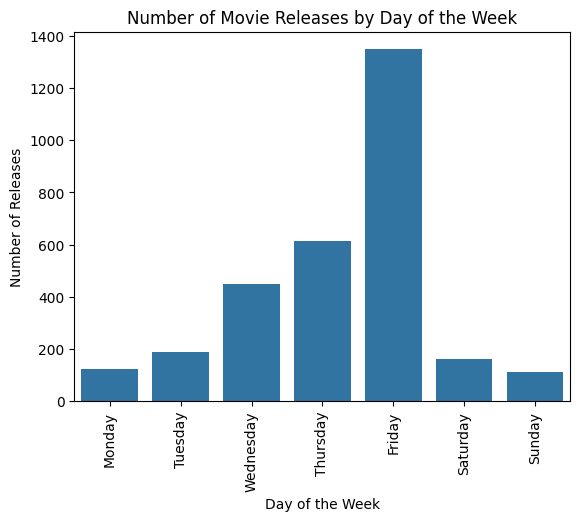

In [141]:
def date(x):
    x = str(x)
    try:
        year = x.split('/')[2]
        if int(year) < 19:
            return x[:-2] + '20' + year
        else:
            return x[:-2] + '19' + year
    except IndexError:
        return '1/1/1990'

train['release_date'] = train['release_date'].fillna('1/1/90')
test['release_date'] = test['release_date'].fillna('1/1/90')

train['release_date'] = train['release_date'].apply(lambda x: date(x))
test['release_date'] = test['release_date'].apply(lambda x: date(x))

train['release_date'] = pd.to_datetime(train['release_date'], format='%m/%d/%Y', errors='coerce')
test['release_date'] = pd.to_datetime(test['release_date'], format='%m/%d/%Y', errors='coerce')

train['release_day'] = train['release_date'].apply(lambda x: x.weekday() if pd.notnull(x) else -1)
train['release_month'] = train['release_date'].apply(lambda x: x.month if pd.notnull(x) else -1)
train['release_year'] = train['release_date'].apply(lambda x: x.year if pd.notnull(x) else -1)

test['release_day'] = test['release_date'].apply(lambda x: x.weekday() if pd.notnull(x) else -1)
test['release_month'] = test['release_date'].apply(lambda x: x.month if pd.notnull(x) else -1)
test['release_year'] = test['release_date'].apply(lambda x: x.year if pd.notnull(x) else -1)

day = train['release_day'].value_counts().sort_index()
sns.barplot(x=day.index, y=day)
plt.gca().set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation='vertical')
plt.ylabel('Number of Releases')
plt.xlabel('Day of the Week')
plt.title('Number of Movie Releases by Day of the Week')
plt.show()

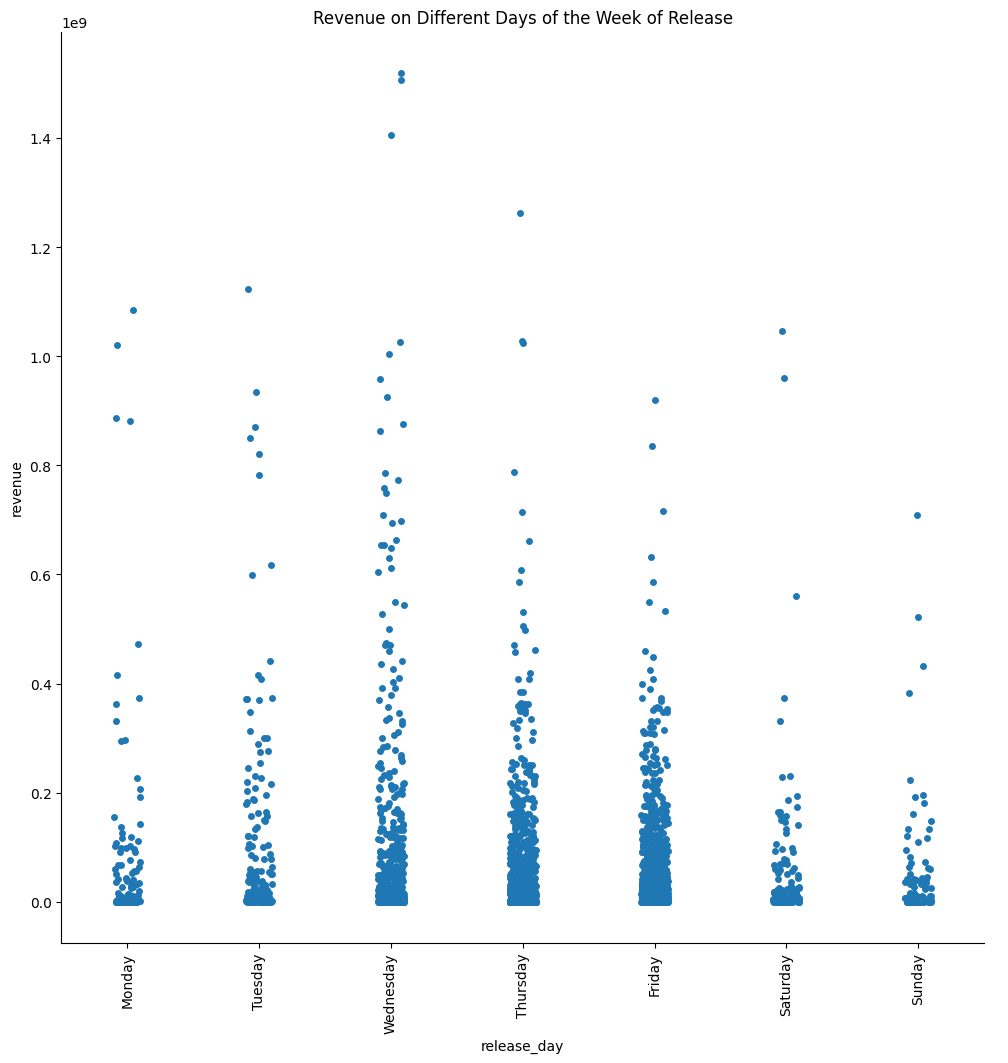

In [142]:
plot = sns.catplot(x='release_day', y='revenue', data=train, height=10, aspect=1)
plot.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation=90)
plt.title('Revenue on Different Days of the Week of Release')
plt.show()


<ipython-input-143-8e45d153ac4d>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation=90)


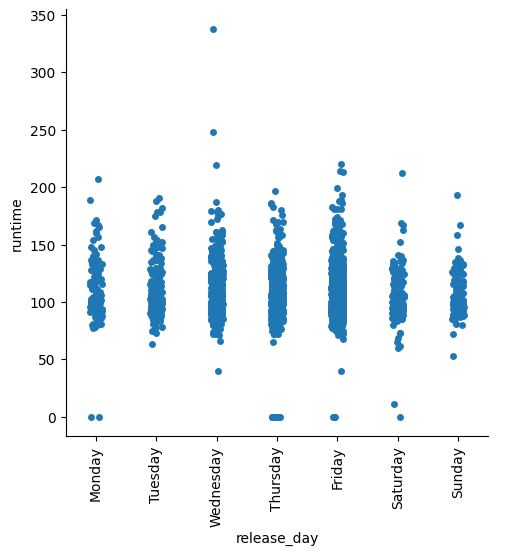

In [143]:
g = sns.catplot(x='release_day', y='runtime', data=train)
for ax in g.axes.flat:
    ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation=90)
plt.show()

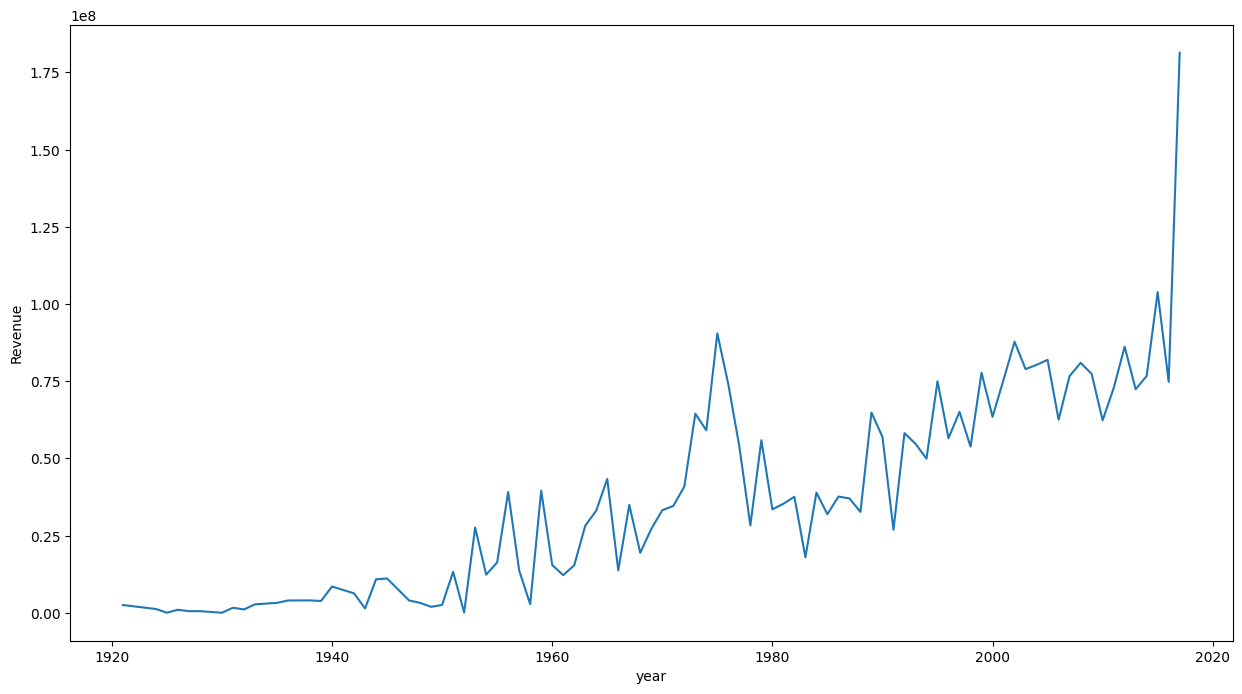

In [144]:
plt.figure(figsize=(15,8))
yearly=train.groupby(train['release_year'])['revenue'].agg('mean')
plt.plot(yearly.index,yearly)
plt.xlabel('year')
plt.ylabel("Revenue")
plt.savefig('fig')

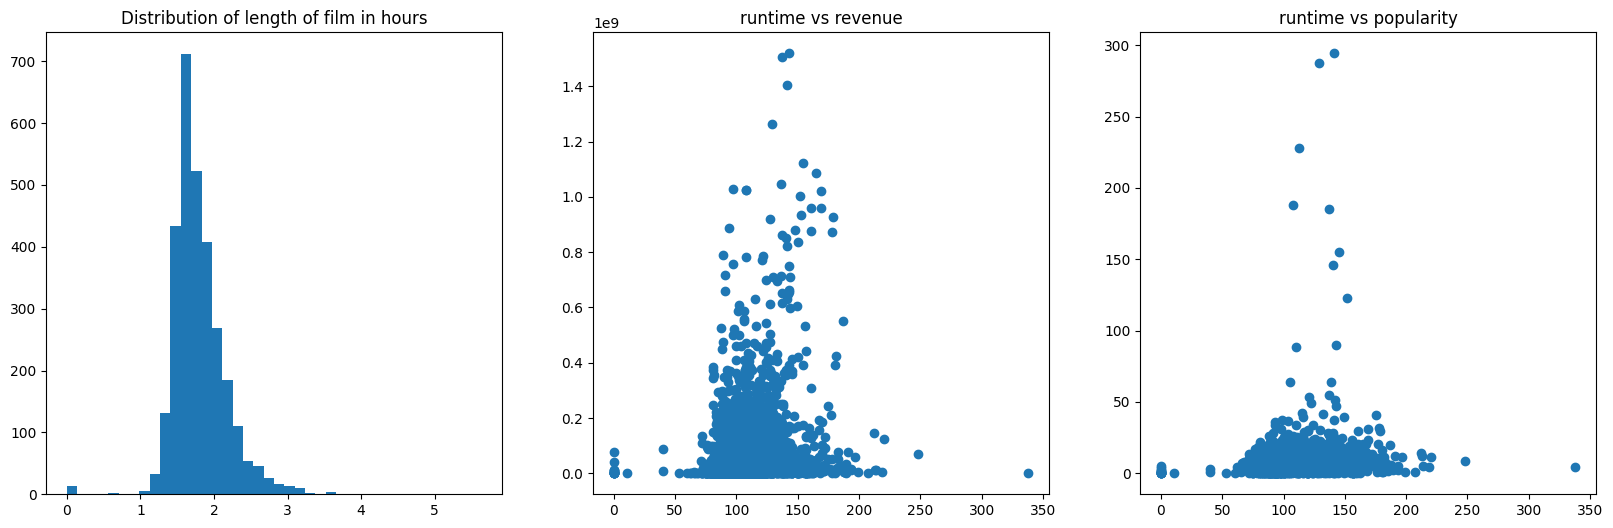

In [145]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.hist(train['runtime'].fillna(0) / 60, bins=40);
plt.title('Distribution of length of film in hours');
plt.subplot(1, 3, 2)
plt.scatter(train['runtime'].fillna(0), train['revenue'])
plt.title('runtime vs revenue');
plt.subplot(1, 3, 3)
plt.scatter(train['runtime'].fillna(0), train['popularity'])
plt.title('runtime vs popularity');

So, above I started by transforming the release dates to ensure correct century formatting, assuming years less than 19 are from the 21st century and those 19 or greater are from the 20th century. I filled missing release dates with '1/1/90' and converted them to datetime format. I then extracted day, month, and year components from the release dates, setting missing values to -1. Visualizing the number of releases by day of the week helped me understand distribution patterns, while analyzing revenue by day of the week revealed potential optimal release days for maximizing revenue. I also explored runtime by release day to identify trends in movie lengths. Observing the average revenue trend over the years highlighted industry changes and audience preferences. Finally, I analyzed the distribution of movie runtimes and their correlation with revenue and popularity, providing insights into factors influencing a movie's success.

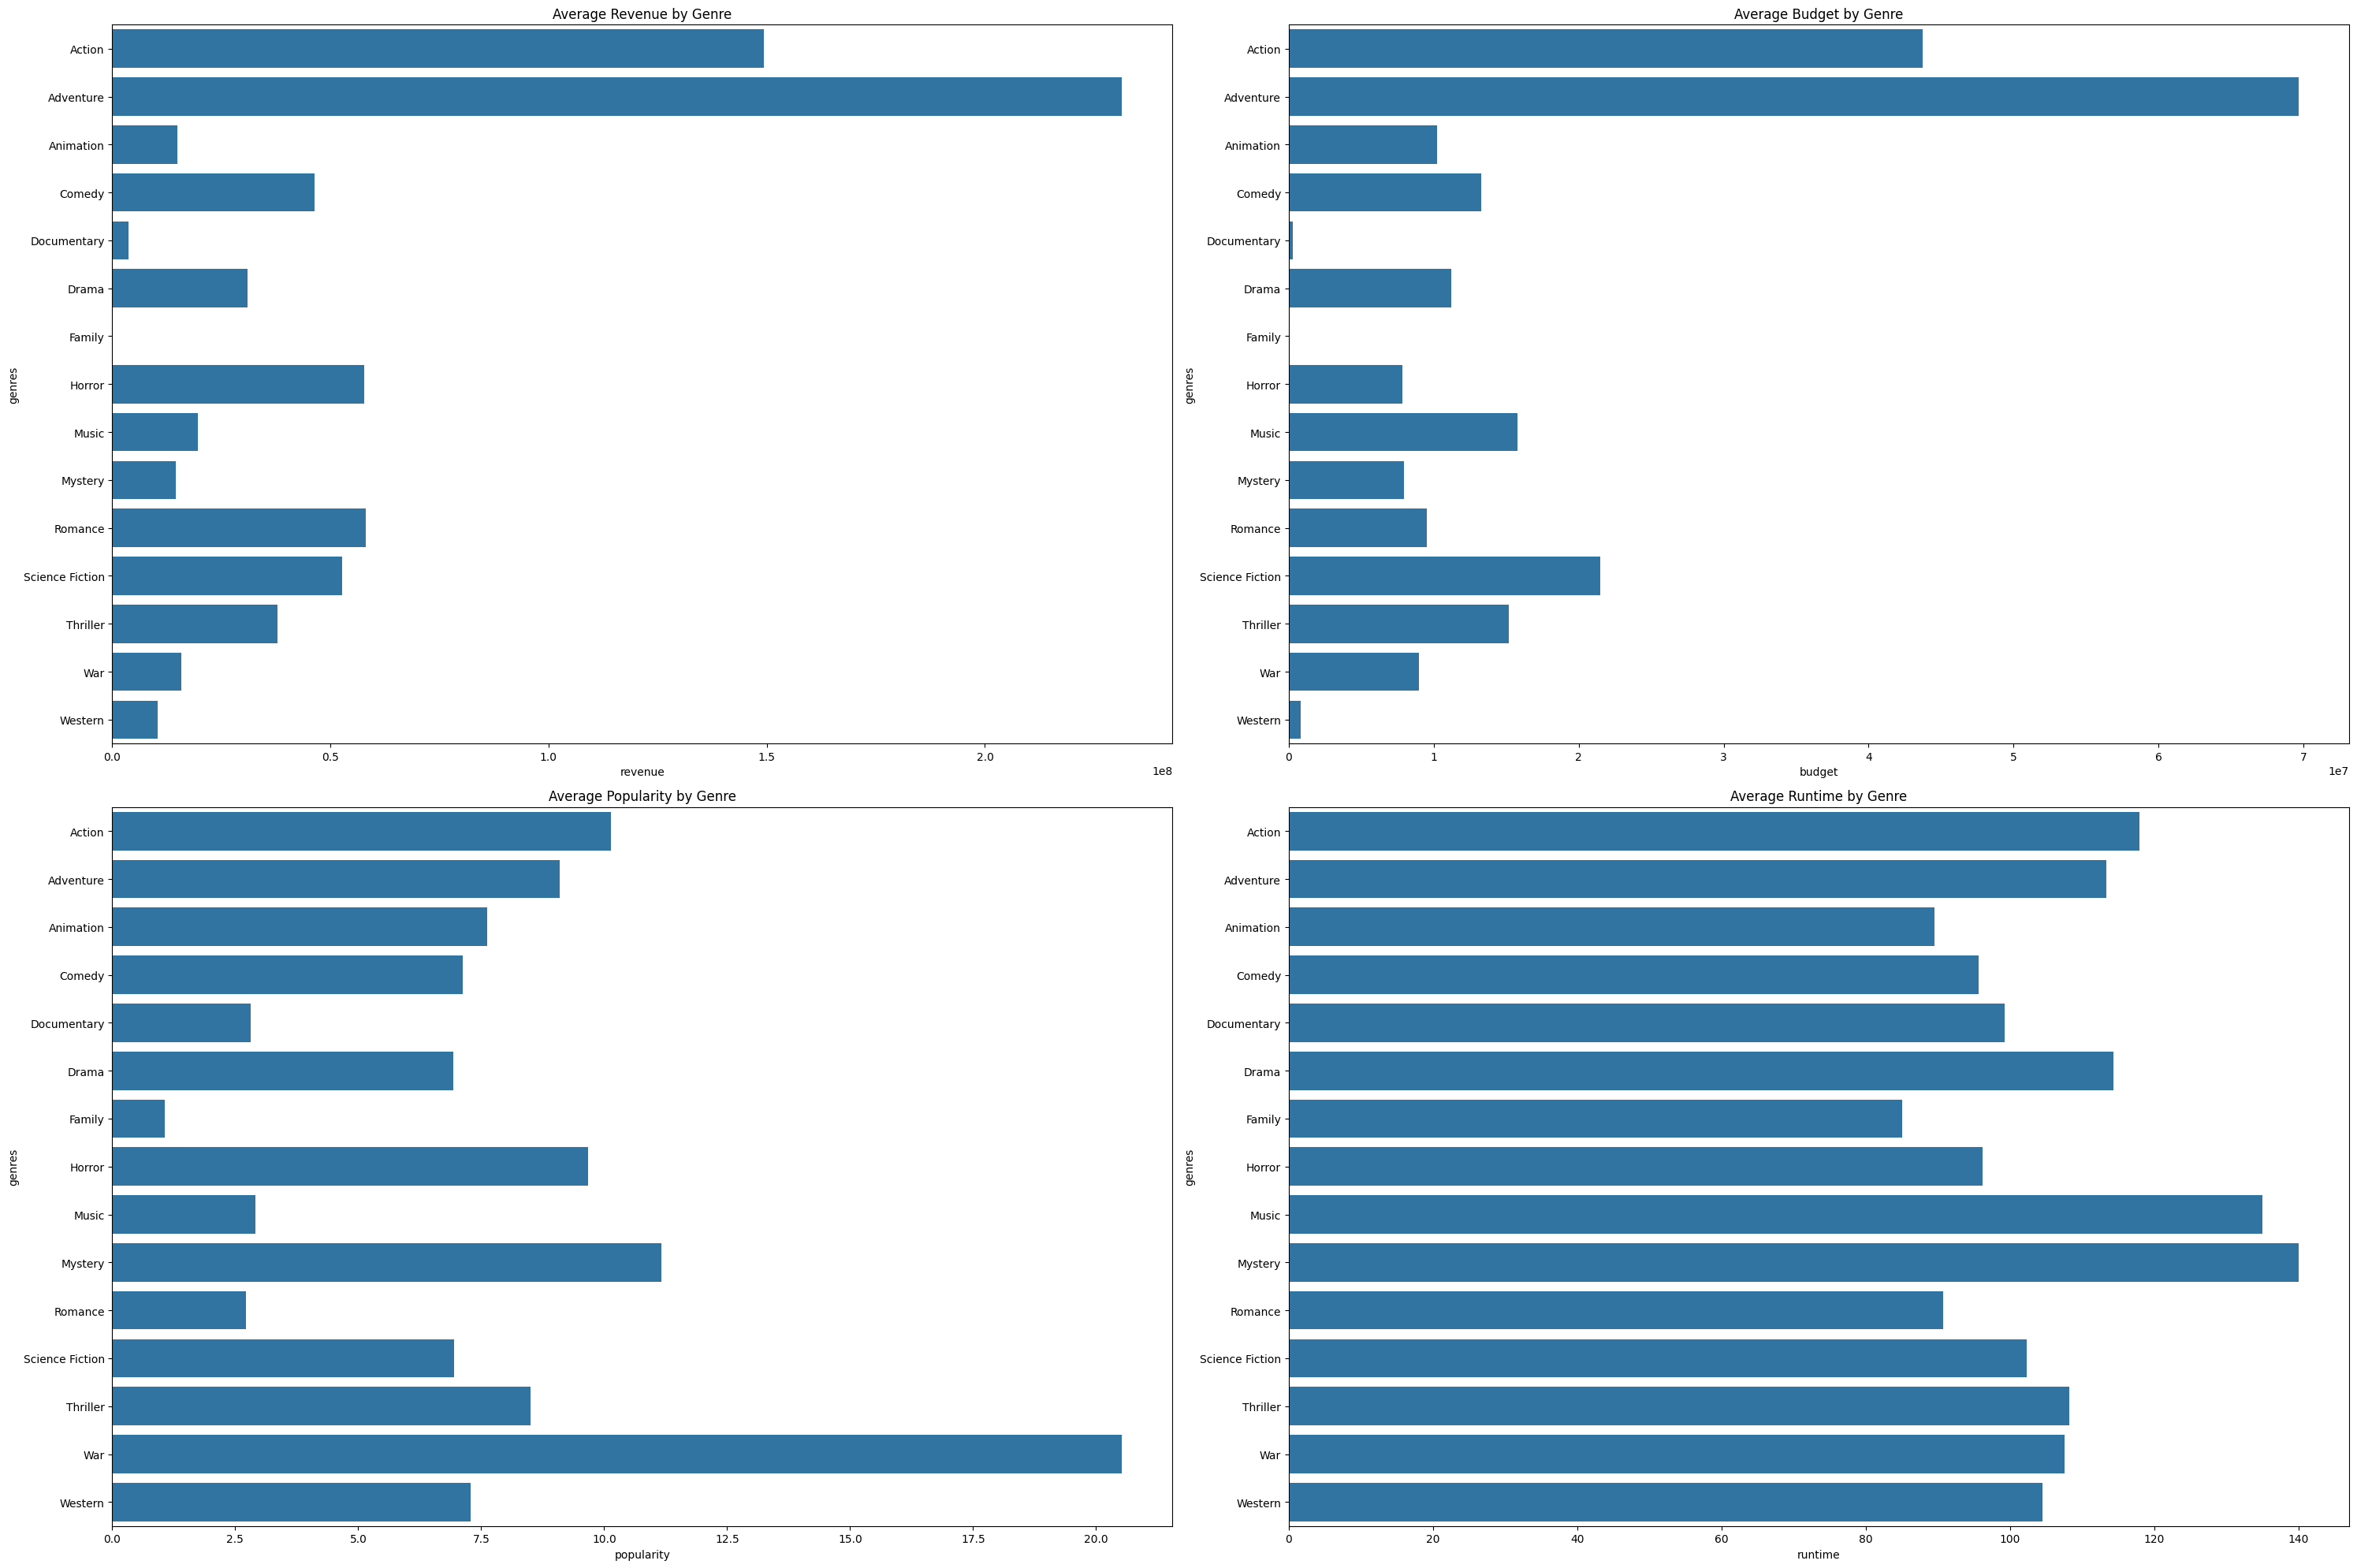

In [146]:
genres=train.loc[train['genres'].str.len()==1][['genres','revenue','budget','popularity','runtime']].reset_index(drop=True)
genres['genres']=genres.genres.apply(lambda x :x[0]['name'])

genres=genres.groupby(genres.genres).agg('mean')
plt.figure(figsize=(30, 20))

plt.subplot(2, 2, 1)
sns.barplot(x=genres['revenue'], y=genres.index, orient='h')
plt.title('Average Revenue by Genre')

plt.subplot(2, 2, 2)
sns.barplot(x=genres['budget'], y=genres.index, orient='h')
plt.title('Average Budget by Genre')

plt.subplot(2, 2, 3)
sns.barplot(x=genres['popularity'], y=genres.index, orient='h')
plt.title('Average Popularity by Genre')

plt.subplot(2, 2, 4)
sns.barplot(x=genres['runtime'], y=genres.index, orient='h')
plt.title('Average Runtime by Genre')

plt.tight_layout()
plt.show()

I analyzed movie data to explore average revenue, budget, popularity, and runtime based on single-genre categorization. I filtered the dataset to include only movies categorized under a single genre, then grouped these movies by genre to compute the mean values for revenue, budget, popularity, and runtime. The results were visualized using bar plots to identify trends: Adventure movies showed the highest average revenue and budget, while Science Fiction and Action genres emerged as the most popular. I also found that Science Fiction movies tended to have longer runtimes compared to Adventure and Action films. This approach aimed to uncover genre-specific insights and trends across these key metrics.

In [147]:
cast=train['cast'].apply(lambda x:[i['name'] for i in x] if x != {} else [])
Counter([i for j in cast for i in j]).most_common(15)

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21)]

In [148]:
crew=train['crew'].apply(lambda x:[i['name'] for i in x] if x != {} else [])
Counter([i for j in crew for i in j]).most_common(15)

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30)]

In the below code, I'm processing movie data to make it ready for machine learning analysis. I start by extracting and cleaning information from nested JSON-like columns (genres, production countries, spoken languages, and production companies) in the train and test datasets. I ensure these columns have consistent data and remove less frequent entries to avoid noise. Next, I concatenate the train and test datasets to apply transformations uniformly. I calculate important ratios, apply log transformations, and create new features like collection name, homepage presence, and counts of keywords, cast, and crew. I use label encoding for categorical data and one-hot encoding for dictionary columns to turn them into binary features. I fill any missing values and normalize numerical columns for consistency. Finally, I drop unnecessary columns and separate the transformed data back into train and test sets. This preprocessing helps in making the data suitable for machine learning algorithms, improving their performance by ensuring the data is clean, consistent, and informative.

In [149]:
def get_json(df):
    global dict_columns
    result = {}
    for col in dict_columns:
        if col not in df.columns:
            print(f"Column '{col}' not found in DataFrame.")
            continue
        d = {}
        rows = df[col].values
        for row in rows:
            if row is None:
                continue
            for i in row:
                if i['name'] not in d:
                    d[i['name']] = 0
                else:
                    d[i['name']] += 1
        result[col] = d
    return result

# Get JSON data for train and test datasets
train_dict = get_json(train)
test_dict = get_json(test)

for col in dict_columns:
    remove = []
    train_id = set(list(train_dict[col].keys()))
    test_id = set(list(test_dict[col].keys()))

    remove += list(train_id - test_id) + list(test_id - train_id)
    for i in train_id.union(test_id) - set(remove):
        if train_dict[col][i] < 10 or i == '':
            remove += [i]
    for i in remove:
        if i in train_dict[col]:
            del train_dict[col][i]
        if i in test_dict[col]:
            del test_dict[col][i]

def prepare_data(df, train_dict):
    # Calculate ratios and log transformations
    df['_budget_runtime_ratio'] = (df['budget'] / df['runtime']).replace([np.inf, -np.inf, np.nan], 0)
    df['_budget_popularity_ratio'] = df['budget'] / df['popularity']
    df['_budget_year_ratio'] = df['budget'].fillna(0) / (df['release_year'] * df['release_year'])
    df['_releaseYear_popularity_ratio'] = df['release_year'] / df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity'] / df['release_year']
    df['budget'] = np.log1p(df['budget'])

    # Collection name and homepage presence
    df['collection_name'] = df['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
    df['has_homepage'] = df['homepage'].isnull().astype(int)

    # Label Encoding
    le = LabelEncoder()
    df['collection_name'] = le.fit_transform(df['collection_name'].fillna('').astype(str))
    df['original_language'] = le.fit_transform(df['original_language'].fillna('').astype(str))

    # Count keywords and cast members
    df['_num_Keywords'] = df['Keywords'].apply(lambda x: len(x) if x != {} else 0)
    df['_num_cast'] = df['cast'].apply(lambda x: len(x) if x != {} else 0)

    # Flags and counts
    df['isbelongto_coll'] = df['belongs_to_collection'].isnull().astype(int)
    df['isTaglineNA'] = df['tagline'].isnull().astype(int)
    df['isOriginalLanguageEng'] = (df['original_language'] == 'en').astype(int)
    df['ismovie_released'] = (df['status'] == 'Released').astype(int)
    df['no_spoken_languages'] = df['spoken_languages'].apply(lambda x: len(x))
    df['original_title_letter_count'] = df['original_title'].str.len()
    df['original_title_word_count'] = df['original_title'].str.split().str.len()
    df['title_word_count'] = df['title'].str.split().str.len()
    df['overview_word_count'] = df['overview'].str.split().str.len()
    df['tagline_word_count'] = df['tagline'].str.split().str.len()

    # Collection ID and production counts
    df['collection_id'] = df['belongs_to_collection'].apply(lambda x: np.nan if len(x) == 0 else x[0]['id'])
    df['production_countries_count'] = df['production_countries'].apply(lambda x: len(x))
    df['production_companies_count'] = df['production_companies'].apply(lambda x: len(x))
    df['cast_count'] = df['cast'].apply(lambda x: len(x))
    df['crew_count'] = df['crew'].apply(lambda x: len(x))
    df['genders_0_crew'] = df['crew'].apply(lambda x: sum(1 for i in x if i['gender'] == 0))
    df['genders_1_crew'] = df['crew'].apply(lambda x: sum(1 for i in x if i['gender'] == 1))
    df['genders_2_crew'] = df['crew'].apply(lambda x: sum(1 for i in x if i['gender'] == 2))

    # One-hot encoding categorical columns
    for col in ['genres', 'production_countries', 'spoken_languages', 'production_companies']:
        df[col] = df[col].apply(lambda x: sorted(list(set([n if n in train_dict[col] else col + '_etc' for n in [d['name'] for d in x]])))).apply(lambda x: ','.join(map(str, x)))
        temp = df[col].str.get_dummies(sep=',')
        df = pd.concat([df, temp], axis=1, sort=False)
    df.drop(['genres_etc'], axis=1, inplace=True)

    # Fill NaN values
    df.fillna(value=0.0, inplace=True)

    # Normalize columns
    cols_to_normalize = [
        'runtime', 'popularity', 'budget', '_budget_runtime_ratio', '_budget_year_ratio',
        '_budget_popularity_ratio', '_releaseYear_popularity_ratio', '_releaseYear_popularity_ratio2',
        '_num_Keywords', '_num_cast', 'no_spoken_languages', 'original_title_letter_count',
        'original_title_word_count', 'title_word_count', 'overview_word_count', 'tagline_word_count',
        'production_countries_count', 'production_companies_count', 'cast_count', 'crew_count',
        'genders_0_crew', 'genders_1_crew', 'genders_2_crew'
    ]
    for col in cols_to_normalize:
        df[col] = normalize(df[[col]], axis=0).ravel()

    # Drop unnecessary columns
    df.drop([
        'belongs_to_collection', 'genres', 'homepage', 'imdb_id', 'overview', 'id',
        'poster_path', 'production_companies', 'production_countries', 'release_date', 'spoken_languages',
        'status', 'title', 'Keywords', 'cast', 'crew', 'original_language', 'original_title', 'tagline',
        'collection_id'
    ], axis=1, inplace=True)

    return df

# Concatenate train and test datasets and preprocess data
test['revenue'] = np.nan
all_data = prepare_data(pd.concat([train, test]), train_dict).reset_index(drop=True)
train = all_data.loc[:train.shape[0] - 1, :]
test = all_data.loc[train.shape[0]:, :]

print(train.shape)

train.drop('revenue', axis=1, inplace=True)
train.head()

(3000, 173)


<ipython-input-149-e2bdcbdffe74>:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop('revenue', axis=1, inplace=True)


,budget,popularity,runtime,log_revenue,log_budget,release_day,release_month,release_year,_budget_runtime_ratio,_budget_popularity_ratio,...,Twentieth Century Fox Film Corporation,UK Film Council,United Artists,Universal Pictures,Village Roadshow Pictures,Walt Disney Pictures,Warner Bros.,Wild Bunch,Working Title Films,production_companies_etc
0,0.013684,0.005148,0.009848,16.326300,16.454568,4,2,2015,0.004637,0.000108,...,0,0,1,0,0,0,0,0,0,0
1,0.014557,0.006459,0.011966,18.370959,17.504390,4,8,2004,0.010905,0.000245,...,0,0,0,0,0,1,0,0,0,0
2,0.012482,0.050345,0.011119,16.387512,15.009433,4,10,2014,0.000968,0.000003,...,0,0,0,0,0,0,0,0,0,1
3,0.011641,0.002486,0.012919,16.588099,13.997833,4,3,2012,0.000303,0.000019,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.000899,0.012495,15.182615,0.000000,3,2,2009,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [153]:
y = train['log_revenue']
X = train.drop(['log_revenue'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

kfold = KFold(n_splits=3, random_state=42, shuffle=True)

print(X.columns)
print(y)

Index(['budget', 'popularity', 'runtime', 'log_budget', 'release_day',
       'release_month', 'release_year', '_budget_runtime_ratio',
       '_budget_popularity_ratio', '_budget_year_ratio',
       ...
       'Twentieth Century Fox Film Corporation', 'UK Film Council',
       'United Artists', 'Universal Pictures', 'Village Roadshow Pictures',
       'Walt Disney Pictures', 'Warner Bros.', 'Wild Bunch',
       'Working Title Films', 'production_companies_etc'],
      dtype='object', length=171)
0       16.326300
1       18.370959
2       16.387512
3       16.588099
4       15.182615
          ...    
2995    14.283442
2996    12.103990
2997    18.309266
2998    18.962792
2999    18.223292
Name: log_revenue, Length: 3000, dtype: float64


In [ ]:
# Define a function to show metrics
def show_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    msle = mean_squared_log_error(y_true, y_pred)
    rmsle = np.sqrt(msle)
    r2 = r2_score(y_true, y_pred)
    print(f"Mean Squared Log Error = {msle}")
    print(f"Root Mean Squared Log Error = {rmsle}")
    print(f"Mean Squared Error = {mse}")
    print(f"Root Mean Squared Error = {rmse}")
    print(f"R^2 = {r2}")

# Define the Keras model
def create_keras_model(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(356, activation='relu', kernel_regularizer=regularizers.l1(0.001), input_shape=(input_dim,)))
    model.add(layers.Dense(356, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
    model.add(layers.Dense(1))
    model.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='mse', metrics=['mean_squared_logarithmic_error'])
    return model

# Function to fit and evaluate Keras model
def evaluate_keras_model(model, X_train, y_train, X_test, y_test, epochs=100):
    history = model.fit(X_train, y_train, epochs=epochs, verbose=0)
    test_pred = model.predict(X_test)
    show_metrics(y_test, test_pred.flatten())

# Function to fit and evaluate LightGBM model
def evaluate_lgb_model(X_train, y_train, X_test, y_test):
    params = {'num_leaves': 30,
              'min_data_in_leaf': 20,
              'objective': 'regression',
              'max_depth': 5,
              'learning_rate': 0.01,
              'boosting': 'gbdt',
              'feature_fraction': 0.9,
              'bagging_freq': 1,
              'bagging_fraction': 0.9,
              'bagging_seed': 11,
              'metric': 'rmse',
              'lambda_l1': 0.2,
              'verbosity': 1000}  # Adjust verbosity here

    model_lgb = lgb.LGBMRegressor(**params, n_estimators=20000, n_jobs=-1)
    model_lgb.fit(X_train, y_train)
    prediction_lgb_test = model_lgb.predict(X_test)
    show_metrics(y_test, prediction_lgb_test)

# Function to fit and evaluate Random Forest model
# def evaluate_rf_model(X_train, y_train, X_test, y_test):
#     rf_base = RandomForestRegressor(random_state=42)
#     rf_base.fit(X_train, y_train)
#     y_rf_base_pred = rf_base.predict(X_test)
#     print("Base Random Forest Regressor:\n")
#     show_metrics(y_test, y_rf_base_pred)

#     n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
#     max_features = ['auto', 'sqrt']
#     max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
#     max_depth.append(None)
#     min_samples_split = [2, 5, 10]
#     min_samples_leaf = [1, 2, 4]
#     bootstrap = [True, False]
#     random_grid = {'n_estimators': n_estimators,
#                    'max_features': max_features,
#                    'max_depth': max_depth,
#                    'min_samples_split': min_samples_split,
#                    'min_samples_leaf': min_samples_leaf,
#                    'bootstrap': bootstrap}

#     print("\nTuned Random Forest Regressor:\n")
#     rf = RandomForestRegressor()
#     rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=75, cv=3, verbose=2, random_state=42, n_jobs=-1)
#     rf_random.fit(X_train, y_train)

#     y_rf_pred = rf_random.predict(X_test)
#     show_metrics(y_test, y_rf_pred)
#     print("\nWith the following parameters:")
#     print(rf_random.best_params_)

# Function to fit and evaluate XGBoost model
def evaluate_xgb_model(X_train, y_train, X_test, y_test):
    params = {'objective': 'reg:squarederror',  # Change to appropriate objective for regression
              'eta': 0.01,
              'max_depth': 6,
              'subsample': 0.6,
              'colsample_bytree': 0.7,
              'seed': 2020,
              'verbosity': 0,  # Adjust verbosity if needed
              'num_boost_round': 20000,  # Large number of boosting rounds
              'early_stopping_rounds': 100}  # Number of rounds to wait for improvement

    train_data = xgb.DMatrix(data=X_train, label=y_train)
    test_data = xgb.DMatrix(data=X_test, label=y_test)

    # Use early stopping by specifying a validation set
    evals_result = {}
    model = xgb.train(params, train_data, num_boost_round=params['num_boost_round'],
                      early_stopping_rounds=params['early_stopping_rounds'],
                      evals=[(train_data, 'train'), (test_data, 'test')],
                      evals_result=evals_result, verbose_eval=False)

    # Predict using the best iteration from early stopping
    best_iteration = model.best_iteration + 1  # Get the best iteration
    test_pred = model.predict(test_data, ntree_limit=model.best_ntree_limit)

    show_metrics(y_test, test_pred)

# Function to fit and evaluate CatBoost model
def evaluate_catboost_model(X_train, y_train, X_test, y_test):
    model = CatBoostRegressor(iterations=10000,
                              learning_rate=0.004,
                              depth=5,
                              colsample_bylevel=0.8,
                              random_seed=2020,
                              bagging_temperature=0.2,
                              metric_period=None)

    model.fit(X_train, y_train, verbose=False)
    test_pred = model.predict(X_test)
    show_metrics(y_test, test_pred)

# Function to fit and evaluate ElasticNet model
def evaluate_elasticnet_model(X_train, y_train, X_test, y_test):
    elastic_net_model = ElasticNet(random_state=42)
    elastic_net_model.fit(X_train, y_train)
    y_elastic_pred = elastic_net_model.predict(X_test)
    show_metrics(y_test, y_elastic_pred)

    print(elastic_net_model.get_params())

    elastic_netCV_model = ElasticNetCV(cv=5, random_state=42)
    elastic_netCV_model.fit(X_train, y_train)
    y_elastic_CV_pred = elastic_netCV_model.predict(X_test)
    show_metrics(y_test, y_elastic_CV_pred)

# Function to fit and evaluate Ridge Regression model
def evaluate_ridge_model(X_train, y_train, X_test, y_test):
    ridged_model = Ridge(random_state=42)
    ridged_model.fit(X_train, y_train)
    y_ridge_pred = ridged_model.predict(X_test)
    show_metrics(y_test, y_ridge_pred)

    ridgeCV_model = RidgeCV(alphas=[0.0005, 0.001, 0.00125, 0.0015, 0.00175, 0.002])
    ridgeCV_model.fit(X_train, y_train)
    y_ridgeCV_pred = ridgeCV_model.predict(X_test)
    show_metrics(y_test, y_ridgeCV_pred)
    print("Optimal alpha: " + str(ridgeCV_model.alpha_))

    # linear kernel
    kernel_ridge_model = KernelRidge(alpha=ridgeCV_model.alpha_)
    kernel_ridge_model.fit(X_train, y_train)
    y_kernel_ridge_pred = kernel_ridge_model.predict(X_test)
    show_metrics(y_test, y_kernel_ridge_pred)

# Function to fit and evaluate Linear Regression model
def evaluate_linear_model(X_train, y_train, X_test, y_test):
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    y_lm_pred = lm.predict(X_test)
    show_metrics(y_test, y_lm_pred)

# Function to fit and evaluate Support Vector Regression model
def evaluate_svr_model(X_train, y_train, X_test, y_test):
    Cval = 100
    eps = 1
    SVRreg = SVR(C=Cval, epsilon=eps)
    SVRreg.fit(X_train, y_train)
    y_pred = SVRreg.predict(X_test)
    show_metrics(y_test, y_pred)

# Assuming X_train, X_test, y_train, y_test are defined earlier
# For Keras model
keras_model = create_keras_model(X_train.shape[1])
print("\nKeras Model:\n")
evaluate_keras_model(keras_model, X_train, y_train, X_test, y_test, epochs=100)

# For LightGBM model
print("\nLightGBM Model:\n")
evaluate_lgb_model(X_train, y_train, X_test, y_test)

# For Random Forest model
# print("\nRandom Forest Model:\n")
# evaluate_rf_model(X_train, y_train, X_test, y_test)

# For XGBoost model
print("\nXGBoost Model with Early Stopping:\n")
evaluate_xgb_model(X_train, y_train, X_test, y_test)

# For CatBoost model
print("\nCatBoost Model:\n")
evaluate_catboost_model(X_train, y_train, X_test, y_test)

# For ElasticNet model
print("\nElasticNet Model:\n")
evaluate_elasticnet_model(X_train, y_train, X_test, y_test)

# For Ridge Regression model
print("\nRidge Regression Model:\n")
evaluate_ridge_model(X_train, y_train, X_test, y_test)

# For Linear Regression model
print("\nLinear Regression Model:\n")
evaluate_linear_model(X_train, y_train, X_test, y_test)

# For Support Vector Regression model
print("\nSupport Vector Regression Model:\n")
evaluate_svr_model(X_train, y_train, X_test, y_test)
